 <font size="5"> Data Engineering Project Retail Store — Part 4 — Analyzing the Data</font>

 <font size="4"> Imports and Function</font>

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymysql
import pandasql as ps

plt.style.use('ggplot')
sns.set_palette('Blues_r')
sns.set_context('notebook')


def mysql(query):
    return pd.read_sql_query(query, connection)

def sql(query):
    return ps.sqldf(query)

 <font size="4"> Step #1. Connect Python to the MySQL Data Warehouse</font>

In [11]:
connection = pymysql.connect(host ='localhost',
                             port=int(3306),
                             user='root',
                             passwd="Qwerty1234/",
                             db='dwh_whiskey')

# Creaeting a cursor object
cursor = connection.cursor()

   <font size="4"> Step #2. Extract the Fact Table data</font>  

In [12]:
query = '''
select 
	f.date,
    d.Day_name as Day,
    d.Month_name as Month,
    d.Year_name as Year,
    f.Product_Name,
    f.Alcohol_Price,
    f.Alcohol_Percent,
    f.Alcohol_Amount,
    c.full_name as customer_name,
    co.country as customer_country,
    f.credit_provider,
    e.full_name as employee_name
from dwh_fact as f
left join whiskey_retail__shop.customers c
on f.customer_id = c.customer_id
left join whiskey_retail__shop.countries as co
on co.country_id = c.country_id 
left join dwh_employees as e
on e.employee_id = f.employee_id
left join dwh_date2 d
on d.Date_key = f.Date_key
order by f.date '''

# Generating a Dataframe according to the query
df = mysql(query)

In [13]:
df

,date,Day,Month,Year,Product_Name,Alcohol_Price,Alcohol_Percent,Alcohol_Amount,customer_name,customer_country,credit_provider,employee_name
0,1990-01-04,Thursday,Jan,1990,Glenfarclas 10 Year Old,35.95,40.0,70.0,Bill Haynie,Morocco,JCB 16 digit,Kelly Ray
1,1990-01-04,Thursday,Jan,1990,Knockando 1975Bot 1988,299.00,43.0,75.0,Mark Salisbury,Guinea,Diners Club / Carte Blanche,Harriet Guillory
2,1990-01-04,Thursday,Jan,1990,Tobermory 24 Year OldOloroso Sherry Finish,275.00,46.3,70.0,Constance Cox,Serbia,VISA 19 digit,Michael Harding
3,1990-01-05,Friday,Jan,1990,Edradour 200021 Year Old Oloroso Finish,305.00,56.2,70.0,Cheryl Hitt,Luxembourg,VISA 19 digit,Dorothy Reece
4,1990-01-08,Monday,Jan,1990,Jura 14 Year Old American Rye Cask,39.95,40.0,70.0,Mildred Robson,Costa Rica,American Express,Judy Archie
...,...,...,...,...,...,...,...,...,...,...,...,...
11318,2020-12-27,Sunday,Dec,2020,Caol Ila 198040 Year Old Xtra Old Particular,1750.00,54.6,70.0,Joshua Hoskins,Zimbabwe,American Express,Lydia Ball
11319,2020-12-28,Monday,Dec,2020,Glen Keith 199622 Year Old Cherry Bakewell Ta...,135.00,46.0,70.0,Carl Oglesby,Guatemala,American Express,Anthony Solomon
11320,2020-12-31,Thursday,Dec,2020,Tomintoul-Glenlivet37 Year Old,800.00,43.0,75.0,Scott Cho,Colombia,VISA 16 digit,Deborah Grant
11321,2020-12-31,Thursday,Dec,2020,Glengoyne Cask StrengthBatch 9,69.95,59.6,70.0,Harold Nixon,Timor-Leste,American Express,Elizabeth Merrell


 <font size="4"> Step #3. Analyze the Data</font> 

   <font size="4">1. pre-processing</font>  

In [14]:
df.dtypes

date                 object
Day                  object
Month                object
Year                 object
Product_Name         object
Alcohol_Price       float64
Alcohol_Percent     float64
Alcohol_Amount      float64
customer_name        object
customer_country     object
credit_provider      object
employee_name        object
dtype: object

In [15]:
# Extracting a list of column
df_columns = df.columns.to_list()

# Iterating through the columns
for column in df_columns:
    
    # If the column is date, change the data type to datetime
    if column == 'date':
        df[column] = pd.to_datetime(df[column])
    
    # If the column is object, change the data type to category
    if df[column].dtype == 'object':
        df[column] = df[column].astype('category')

In [16]:
df.dtypes

date                datetime64[ns]
Day                       category
Month                     category
Year                      category
Product_Name              category
Alcohol_Price              float64
Alcohol_Percent            float64
Alcohol_Amount             float64
customer_name             category
customer_country          category
credit_provider           category
employee_name             category
dtype: object

 <font size="4"> 2. Descriptive Analysis & Visualization</font>

 <font size="3"> Q1 — Which products produce the most profit?</font>

In [19]:
query = '''
select 
    count(*) as Number_Of_Transactions, 
    Product_Name, 
    sum(Alcohol_Price) as Profit
    
from df
group by Product_Name
order by sum(Alcohol_Price) desc
limit 5
'''

top_5_products = sql(query)
top_5_products

,Number_Of_Transactions,Product_Name,Profit
0,9,Black Bowmore 1964 Aston Martin DB531 Year Old,1620000.0
1,7,Glenlivet Generation 194080 Year Old Gordon &...,770000.0
2,6,Milton (Strathisla) 194972 Year Old G&M Priva...,300000.0
3,9,"Brora Triptych (1972, 1977 and 1982)",297000.0
4,14,Glen Grant 195270 Year Old Queen's Platinum J...,280000.0


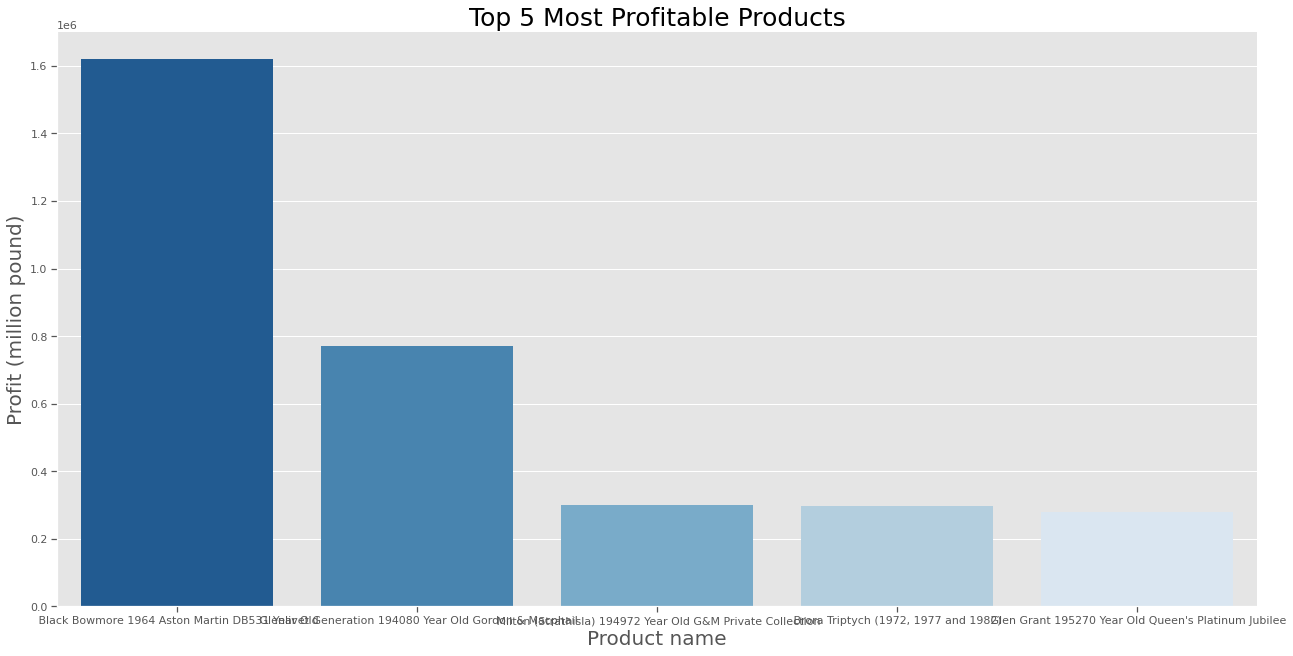

In [20]:
sns.catplot(data = top_5_products, x = 'Product_Name', y = 'Profit', 
            kind = 'bar', palette='Blues_r', height = 9, aspect = 2)
plt.xlabel('Product name',size = 20)
plt.ylabel('Profit (million pound)',size = 20)

plt.title('Top 5 Most Profitable Products',size = 25)

plt.show()

 <font size="3"> Q2 — Which products people usually buy?</font>

 <font size="3"> Extracting the most commonly sold products</font>

In [22]:

query = '''
select 
    count(*) as Number_Of_Transactions, 
    Product_Name
    
from df
group by Product_Name
order by count(*) desc
'''

most_bought_products = sql(query)
most_bought_products

,Number_Of_Transactions,Product_Name
0,47,Glen Ord 12 Year OldBot.1990s
1,37,Glenfiddich 12 Year OldCaoran Reserve
2,34,Balvenie 17 Year OldPeated Cask
3,33,Balvenie 10 Year OldFounder's Reserve
4,30,Tormore 10 Year OldBot.1980s
...,...,...
1337,2,Glen Grant 196554 Year Old Gordon & MacPhail ...
1338,2,Bunnahabhain 197342 Year Old Rare Reserve
1339,1,Laphroaig 27 Year OldBot.2017
1340,1,Laphroaig 25 Year OldCask Strength Bot.2019


<font size="3"> Creating a probability mass function</font>

In [23]:
pmf=most_bought_products['Number_Of_Transactions']/sum(most_bought_products['Number_Of_Transactions'])
data=np.column_stack((most_bought_products['Product_Name'],pmf))

In [24]:
proba=pd.DataFrame({"Product_Name": most_bought_products['Product_Name'] , "probability" : pmf})

In [25]:
proba

,Product_Name,probability
0,Glen Ord 12 Year OldBot.1990s,0.004151
1,Glenfiddich 12 Year OldCaoran Reserve,0.003268
2,Balvenie 17 Year OldPeated Cask,0.003003
3,Balvenie 10 Year OldFounder's Reserve,0.002914
4,Tormore 10 Year OldBot.1980s,0.002649
...,...,...
1337,Glen Grant 196554 Year Old Gordon & MacPhail ...,0.000177
1338,Bunnahabhain 197342 Year Old Rare Reserve,0.000177
1339,Laphroaig 27 Year OldBot.2017,0.000088
1340,Laphroaig 25 Year OldCask Strength Bot.2019,0.000088


 <font size="3"> Q3 — Are there any interesting patterns as to when customers like to buy whiskey? If so what are they?</font>  

In [29]:
query = '''
select 
    count(*) as Number_Of_Transactions, 
    Day,
    month
    
from df
group by month,Day
order by count(*) desc
'''

most_bought_products_by_MD = sql(query)


In [30]:
most_bought_products_by_MD

,Number_Of_Transactions,Day,Month
0,163,Tuesday,Jul
1,162,Sunday,Jan
2,162,Tuesday,May
3,154,Thursday,Aug
4,154,Monday,Jun
...,...,...,...
79,113,Friday,Jun
80,112,Thursday,Oct
81,108,Monday,Feb
82,108,Tuesday,Feb


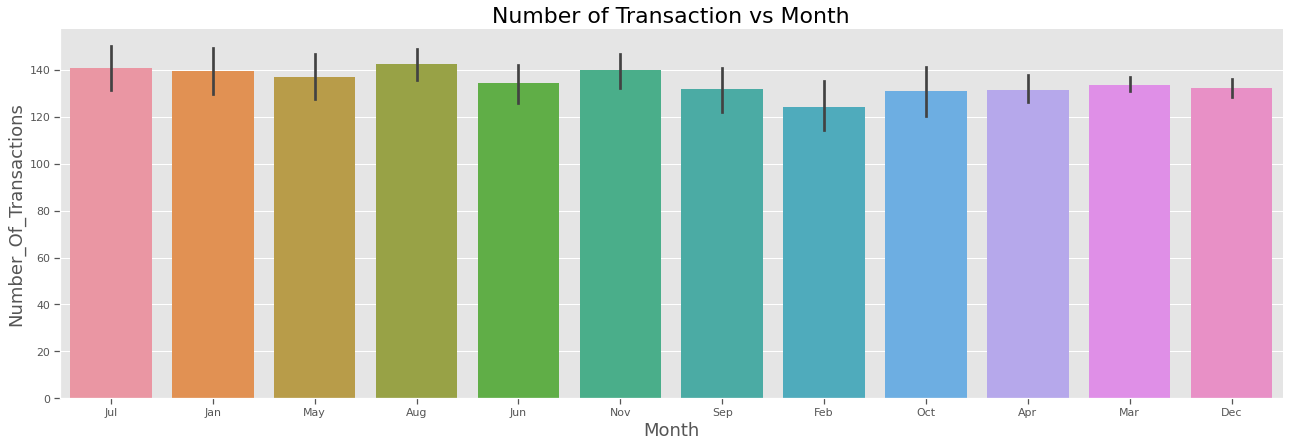

In [31]:

sns.catplot(data = most_bought_products_by_month, 
            y = 'Number_Of_Transactions', x = 'Month', kind = 'bar',
           height = 6, aspect = 3)
plt.xlabel('Month', size = 18)
plt.ylabel('Number_Of_Transactions', size = 18)
plt.title('Number of Transaction vs Month', size = 22)
plt.show()

No apparent patterns or differences by month and day. Seems like clients don’t really mind the day or month of when they buy their whisky.

   <font size="3"> Q4 — Are we growing as a company in terms of profits or not?</font> 

In [32]:
query=" select sum(alcohol_Price) as money ,   year from df group by year order by year asc;"
dt_profits=sql(query)
dt_profits

,money,Year
0,553307.60,1990
1,281735.90,1991
2,387725.20,1992
3,335845.05,1993
4,250247.65,1994
5,439859.80,1995
6,317650.40,1996
7,460748.25,1997
8,353133.20,1998
9,535326.15,1999


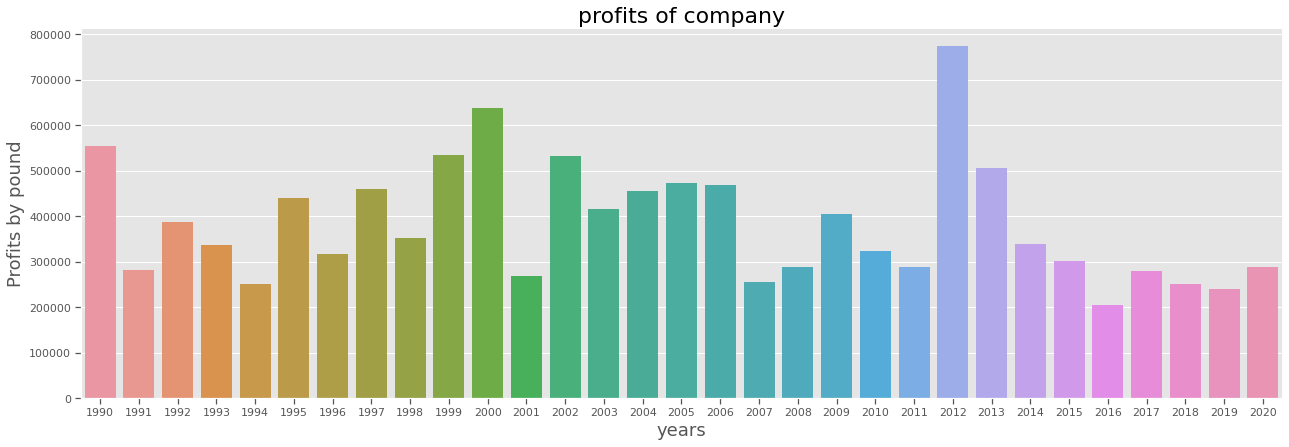

In [33]:

sns.catplot(data = dt_profits, 
            y = 'money', x = 'Year', kind = 'bar',
           height = 6, aspect = 3)
plt.xlabel('years', size = 18)
plt.ylabel('Profits by pound', size = 18)
plt.title('profits of company', size = 22)
plt.show()

 <font size="3"> Q5 — From which counties do most of the customers come from</font>  

In [34]:
query=" select sum(alcohol_Price) as money ,  customer_country from df group by customer_country order by money desc;"
dt_country=sql(query)
dt_country.head(10)

,money,customer_country
0,510390.05,Malawi
1,280712.45,Bangladesh
2,271586.70,San Marino
3,254330.45,Tanzania
4,233224.80,Korea
5,223207.65,Netherlands
6,216345.35,Tokelau
7,211076.65,Oman
8,202252.80,Cuba
9,170970.00,Peru


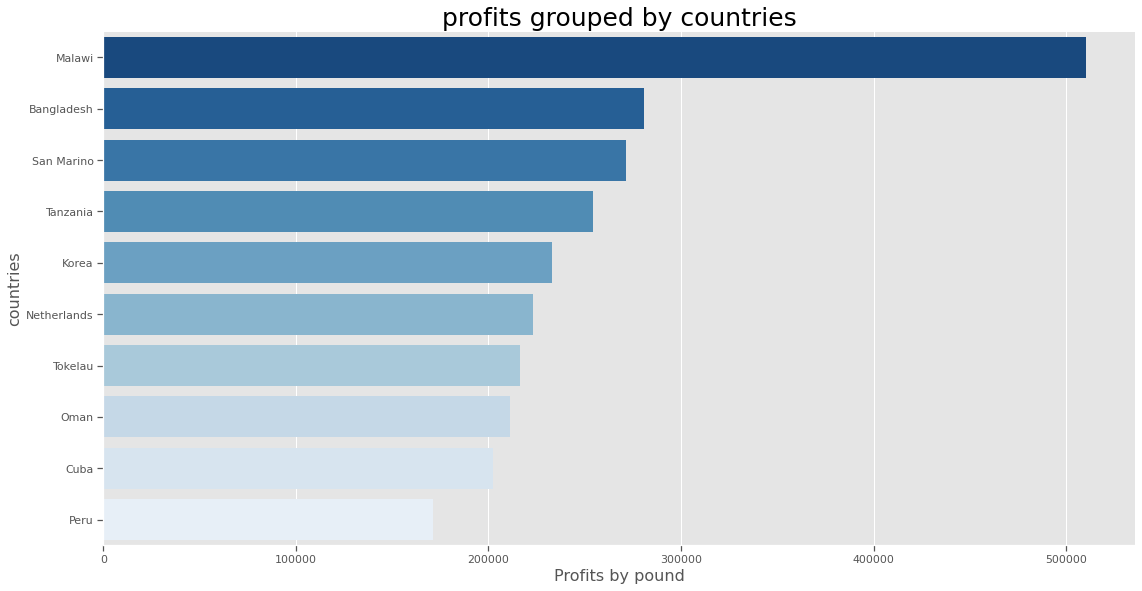

In [35]:
sns.catplot(data = dt_country.head(10), x = 'money', y = 'customer_country', 
            kind = 'bar', palette='Blues_r', height = 8, aspect = 2)
plt.xlabel('Profits by pound',size = 16)
plt.ylabel('countries',size = 16)

plt.title('profits grouped by countries',size = 25)

plt.show()

Look’s like the British Virgin Islands, Bahamas, Sierra Leone, and Switzerland are the countries with the most customers.